# **Experiment 1** - (Text-only) BERT, RoBERTa, ELECTRA as text embedding

## BERT

In [1]:
!pip install -q tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 35.8 MB/s eta 0:00:00


In [12]:
from tensorflow.python.platform.tf_logging import warn
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import re
from os import listdir
import shutil
import glob
import random
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow_text as text
tf.get_logger().setLevel('ERROR')
import warnings

warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
BASE_SAVE_LOCATION = "/content/drive/MyDrive/multimodal-news"
CHECKPOINT_FILEPATH = '/content/drive/MyDrive/multimodal-news/twitter-models/'

## Load the dataframes

In [14]:
#Load training df
train_df_model = pd.read_pickle(BASE_SAVE_LOCATION+"/twitter-train.pickle")
test_df_model = pd.read_pickle(BASE_SAVE_LOCATION+"/twitter-test.pickle")
print(train_df_model.shape, test_df_model.shape)

(14258, 3) (1923, 3)


In [15]:
# This is for Talos as it doesn't take TF DataSet as input
X_train = train_df_model.copy()
y_train = X_train.pop('label')

X_test = test_df_model.copy()
y_test = X_test.pop('label')

# Data input pipeline

In [16]:
# Define TF Hub paths to the BERT encoder and its preprocessor
bert_model_path = (
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1"
)
bert_preprocess_path = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [17]:
def make_bert_preprocessing_model(sentence_features, seq_length=128):
    """Returns Model mapping string features to BERT inputs.

  Args:
    sentence_features: A list with the names of string-valued features.
    seq_length: An integer that defines the sequence length of BERT inputs.

  Returns:
    A Keras Model that can be called on a list or dict of string Tensors
    (with the order or names, resp., given by sentence_features) and
    returns a dict of tensors for input to BERT.
  """

    input_segments = [
        tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
        for ft in sentence_features
    ]

    # Tokenize the text to word pieces.
    bert_preprocess = hub.load(bert_preprocess_path)
    tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name="tokenizer")
    segments = [tokenizer(s) for s in input_segments]

    # Optional: Trim segments in a smart way to fit seq_length.
    # Simple cases (like this example) can skip this step and let
    # the next step apply a default truncation to approximately equal lengths.
    truncated_segments = segments

    # Pack inputs. The details (start/end token ids, dict of output tensors)
    # are model-dependent, so this gets loaded from the SavedModel.
    packer = hub.KerasLayer(
        bert_preprocess.bert_pack_inputs,
        arguments=dict(seq_length=seq_length),
        name="packer",
    )
    model_inputs = packer(truncated_segments)
    return keras.Model(input_segments, model_inputs)


In [18]:
bert_preprocess_model = make_bert_preprocessing_model(["text_1"])
bert_preprocess_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_1 (InputLayer)         [(None,)]                 0         
                                                                 
 tokenizer (KerasLayer)      (None, None, None)        0         
                                                                 
 packer (KerasLayer)         {'input_word_ids': (None  0         
                             , 128),                             
                              'input_type_ids': (None            
                             , 128),                             
                              'input_mask': (None, 12            
                             8)}                                 
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________

In [19]:
idx = np.random.choice(len(train_df_model))
row = train_df_model.iloc[idx]
sample_text_1, sample_text_2 = row["tweetText"], row["tweetText"]
print(f"Text 1: {sample_text_1}")
print(f"Text 2: {sample_text_2}")

test_text = [np.array([sample_text_1])]
text_preprocessed = bert_preprocess_model(test_text)

print("Keys           : ", list(text_preprocessed.keys()))
print("Shape Word Ids : ", text_preprocessed["input_word_ids"].shape)
print("Word Ids       : ", text_preprocessed["input_word_ids"][0, :16])
print("Shape Mask     : ", text_preprocessed["input_mask"].shape)
print("Input Mask     : ", text_preprocessed["input_mask"][0, :16])
print("Shape Type Ids : ", text_preprocessed["input_type_ids"].shape)
print("Type Ids       : ", text_preprocessed["input_type_ids"][0, :16])


Text 1: “@RoyalMobKev #Sandy brought back up (A Shark) to Jersey.. http://t.co/dRSO6wRf smh wow” crazyyy!!!!
Text 2: “@RoyalMobKev #Sandy brought back up (A Shark) to Jersey.. http://t.co/dRSO6wRf smh wow” crazyyy!!!!
Keys           :  ['input_word_ids', 'input_type_ids', 'input_mask']
Shape Word Ids :  (1, 128)
Word Ids       :  tf.Tensor(
[  101  1523  1030  2548  5302  2497  3489  2615  1001  7525  2716  2067
  2039  1006  1037 11420], shape=(16,), dtype=int32)
Shape Mask     :  (1, 128)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 128)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)


In [20]:
def dataframe_to_dataset(dataframe):
    columns = ['tweetText', 'label']
    dataframe = dataframe[columns].copy()
    labels = dataframe.pop("label")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

## Preprocessing utilities

In [21]:
resize = (224, 224)
bert_input_features = ["input_word_ids", "input_type_ids", "input_mask"]

In [22]:
def preprocess_text(text_1):
  text_1 = tf.convert_to_tensor([text_1])
  output = bert_preprocess_model([text_1])
  output = {feature: tf.squeeze(output[feature]) for feature in bert_input_features}
  return output

In [23]:
def preprocess_text_and_image(sample):
  text = preprocess_text(sample["tweetText"])
  return {"text": text}

In [24]:
batch_size = 32
auto = tf.data.AUTOTUNE

In [25]:
def prepare_dataset(dataframe, training=True):
  ds = dataframe_to_dataset(dataframe)
  if training:
      ds = ds.shuffle(len(train_df_model))
  ds = ds.map(lambda x, y: (preprocess_text_and_image(x), y)).cache()
  ds = ds.batch(batch_size).prefetch(auto)
  return ds

In [26]:
train_ds = prepare_dataset(train_df_model)
test_ds = prepare_dataset(test_df_model, False)

## Model Building

### Projection

In [27]:
def project_embeddings(
    embeddings, num_projection_layers, projection_dims, dropout_rate
):
    projected_embeddings = keras.layers.Dense(units=projection_dims)(embeddings)
    for _ in range(num_projection_layers):
        x = tf.nn.gelu(projected_embeddings)
        x = keras.layers.Dense(projection_dims)(x)
        x = keras.layers.Dropout(dropout_rate)(x)
        x = keras.layers.Add()([projected_embeddings, x])
        projected_embeddings = keras.layers.LayerNormalization()(x)
    return projected_embeddings


### Text Encoder

In [28]:
def create_text_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained BERT model to be used as the base encoder.
    bert = hub.KerasLayer(bert_model_path, name="bert",)
    # Set the trainability of the base encoder.
    bert.trainable = trainable

    # Receive the text as inputs.
    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    inputs = {
        feature: keras.Input(shape=(128,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    # Generate embeddings for the preprocessed text using the BERT model.
    embeddings = bert(inputs)["pooled_output"]

    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the text encoder model.
    return keras.Model(inputs, outputs, name="text_encoder")

## TextOnly model

In [29]:
def create_text_only_model(
    num_projection_layers=0,
    projection_dims=128,
    dropout_rate=0.1,
    text_trainable=False,
    attention=False
):
    # Receive the text as inputs.
    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    text_inputs = {
        feature: keras.Input(shape=(128,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    text_encoder = create_text_encoder(
        num_projection_layers, projection_dims, dropout_rate, text_trainable
    )

    # Fetch the embedding projections.
    text_projections = text_encoder(text_inputs)
    text_projections = keras.layers.Dropout(dropout_rate)(text_projections)
    outputs = keras.layers.Dense(1, activation="sigmoid")(text_projections)
    return keras.Model([text_inputs], outputs)

In [30]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics= [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

In [31]:
text_only_model = create_text_only_model(num_projection_layers=1, projection_dims=128, dropout_rate=0.0)

In [32]:
epochs = 10
batch_size = 32

In [33]:
text_only_model.compile(
    optimizer=tf.keras.optimizers.Adam(), loss=loss, metrics=metrics
)
history = text_only_model.fit(train_ds, validation_data=test_ds, epochs=epochs, batch_size=batch_size)

Epoch 1/10
446/446 [==============================] - 24s 34ms/step - loss: 0.5824 - accuracy: 0.6987 - precision: 0.6109 - recall: 0.3419 - val_loss: 1.3568 - val_accuracy: 0.3661 - val_precision: 0.4189 - val_recall: 0.0257
Epoch 2/10
446/446 [==============================] - 7s 17ms/step - loss: 0.5317 - accuracy: 0.7357 - precision: 0.6656 - recall: 0.4659 - val_loss: 1.2974 - val_accuracy: 0.3734 - val_precision: 0.5147 - val_recall: 0.0290
Epoch 3/10
446/446 [==============================] - 7s 15ms/step - loss: 0.5056 - accuracy: 0.7533 - precision: 0.6970 - recall: 0.5005 - val_loss: 1.2272 - val_accuracy: 0.4015 - val_precision: 0.6772 - val_recall: 0.0886
Epoch 4/10
446/446 [==============================] - 7s 16ms/step - loss: 0.4850 - accuracy: 0.7675 - precision: 0.7222 - recall: 0.5268 - val_loss: 1.2353 - val_accuracy: 0.4004 - val_precision: 0.6184 - val_recall: 0.1168
Epoch 5/10
446/446 [==============================] - 10s 22ms/step - loss: 0.4694 - accuracy: 0.77

Plot training loss vs testing loss

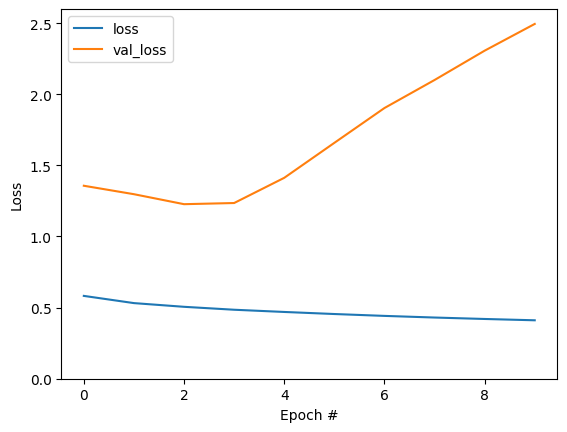

In [34]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

Plot training accuracy vs testing accuracy

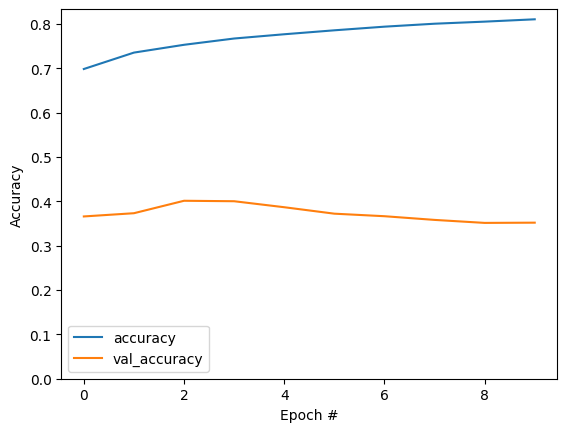

In [35]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

In [36]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score

In [37]:
y_test = np.concatenate([y for x, y in test_ds], axis=0)

In [38]:
y_pred = text_only_model.predict(test_ds)
y_pred = [1 if i>=0.5 else 0 for i in y_pred]
print(f'Accuracy == {accuracy_score(y_test,y_pred)}')
print(f'F1 == {f1_score(y_test,y_pred,average=None)}')
print(f'Precision == {precision_score(y_test,y_pred,average=None)}')
print(f'Recall == {recall_score(y_test,y_pred,average=None)}')

61/61 [==============================] - 1s 12ms/step
Accuracy == 0.35205408216328654
F1 == [0.50040096 0.07840237]
Precision == [0.35095613 0.36551724]
Recall == [0.87150838 0.04391052]


## RoBERTa

In [39]:
# Define TF Hub paths to the BERT encoder and its preprocessor
bert_model_path = (
    "https://tfhub.dev/jeongukjae/roberta_en_cased_L-12_H-768_A-12/1"
)
bert_preprocess_path = "https://tfhub.dev/jeongukjae/roberta_en_cased_preprocess/1"

In [40]:
def make_bert_preprocessing_model(sentence_features, seq_length=128):
    """Returns Model mapping string features to BERT inputs.

  Args:
    sentence_features: A list with the names of string-valued features.
    seq_length: An integer that defines the sequence length of BERT inputs.

  Returns:
    A Keras Model that can be called on a list or dict of string Tensors
    (with the order or names, resp., given by sentence_features) and
    returns a dict of tensors for input to BERT.
  """

    input_segments = [
        tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
        for ft in sentence_features
    ]

    # Tokenize the text to word pieces.
    bert_preprocess = hub.load(bert_preprocess_path)
    tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name="tokenizer")
    segments = [tokenizer(s) for s in input_segments]

    # Optional: Trim segments in a smart way to fit seq_length.
    # Simple cases (like this example) can skip this step and let
    # the next step apply a default truncation to approximately equal lengths.
    truncated_segments = segments

    # Pack inputs. The details (start/end token ids, dict of output tensors)
    # are model-dependent, so this gets loaded from the SavedModel.
    packer = hub.KerasLayer(
        bert_preprocess.bert_pack_inputs,
        arguments=dict(seq_length=seq_length),
        name="packer",
    )
    model_inputs = packer(truncated_segments)
    return keras.Model(input_segments, model_inputs)


In [41]:
bert_preprocess_model = make_bert_preprocessing_model(["text_1"])
bert_preprocess_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_1 (InputLayer)         [(None,)]                 0         
                                                                 
 tokenizer (KerasLayer)      (None, None)              0         
                                                                 
 packer (KerasLayer)         {'input_word_ids': (None  0         
                             , 128),                             
                              'input_type_ids': (None            
                             , 128),                             
                              'input_mask': (None, 12            
                             8)}                                 
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________

In [42]:
idx = np.random.choice(len(train_df_model))
row = train_df_model.iloc[idx]
sample_text_1, sample_text_2 = row["tweetText"], row["tweetText"]
print(f"Text 1: {sample_text_1}")
print(f"Text 2: {sample_text_2}")

test_text = [np.array([sample_text_1])]
text_preprocessed = bert_preprocess_model(test_text)

print("Keys           : ", list(text_preprocessed.keys()))
print("Shape Word Ids : ", text_preprocessed["input_word_ids"].shape)
print("Word Ids       : ", text_preprocessed["input_word_ids"][0, :16])
print("Shape Mask     : ", text_preprocessed["input_mask"].shape)
print("Input Mask     : ", text_preprocessed["input_mask"][0, :16])
print("Shape Type Ids : ", text_preprocessed["input_type_ids"].shape)
print("Type Ids       : ", text_preprocessed["input_type_ids"][0, :16])


Text 1: Hello Sandy http://t.co/9fBi7d62
Text 2: Hello Sandy http://t.co/9fBi7d62
Keys           :  ['input_word_ids', 'input_type_ids', 'input_mask']
Shape Word Ids :  (1, 128)
Word Ids       :  tf.Tensor(
[    0 31414 10234  2054   640    90     4   876    73   466   506 37426
   406   417  5379     2], shape=(16,), dtype=int32)
Shape Mask     :  (1, 128)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 128)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)


In [43]:
def dataframe_to_dataset(dataframe):
    columns = ['tweetText', 'label']
    dataframe = dataframe[columns].copy()
    labels = dataframe.pop("label")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

## Preprocessing utilities

In [44]:
resize = (224, 224)
bert_input_features = ["input_word_ids", "input_type_ids", "input_mask"]

In [45]:
def preprocess_text(text_1):
  text_1 = tf.convert_to_tensor([text_1])
  output = bert_preprocess_model([text_1])
  output = {feature: tf.squeeze(output[feature]) for feature in bert_input_features}
  return output

In [46]:
def preprocess_text_and_image(sample):
  text = preprocess_text(sample["tweetText"])
  return {"text": text}

In [47]:
batch_size = 32
auto = tf.data.AUTOTUNE

In [48]:
def prepare_dataset(dataframe, training=True):
  ds = dataframe_to_dataset(dataframe)
  if training:
      ds = ds.shuffle(len(train_df_model))
  ds = ds.map(lambda x, y: (preprocess_text_and_image(x), y)).cache()
  ds = ds.batch(batch_size).prefetch(auto)
  return ds

In [49]:
train_ds = prepare_dataset(train_df_model)
test_ds = prepare_dataset(test_df_model, False)

## Model Building

In [50]:
def create_text_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained BERT model to be used as the base encoder.
    bert = hub.KerasLayer(bert_model_path, name="bert",)
    # Set the trainability of the base encoder.
    bert.trainable = trainable

    # Receive the text as inputs.
    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    inputs = {
        feature: keras.Input(shape=(128,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    # Generate embeddings for the preprocessed text using the BERT model.
    embeddings = bert(inputs)["pooled_output"]

    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the text encoder model.
    return keras.Model(inputs, outputs, name="text_encoder")

## TextOnly model

In [51]:
def create_text_only_model(
    num_projection_layers=0,
    projection_dims=128,
    dropout_rate=0.1,
    text_trainable=False,
    attention=False
):
    # Receive the text as inputs.
    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    text_inputs = {
        feature: keras.Input(shape=(128,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    text_encoder = create_text_encoder(
        num_projection_layers, projection_dims, dropout_rate, text_trainable
    )

    # Fetch the embedding projections.
    text_projections = text_encoder(text_inputs)
    text_projections = keras.layers.Dropout(dropout_rate)(text_projections)
    outputs = keras.layers.Dense(1, activation="sigmoid")(text_projections)
    return keras.Model([text_inputs], outputs)

In [52]:
text_only_model1 = create_text_only_model(num_projection_layers=1, projection_dims=128, dropout_rate=0.0)

In [53]:
epochs = 10
batch_size = 32

In [54]:
text_only_model1.compile(
    optimizer=tf.keras.optimizers.Adam(), loss=loss, metrics=metrics
)
history1 = text_only_model1.fit(train_ds, validation_data=test_ds, epochs=epochs, batch_size=batch_size)

Epoch 1/10
446/446 [==============================] - 148s 307ms/step - loss: 0.6596 - accuracy: 0.6166 - precision: 0.3725 - recall: 0.0218 - val_loss: 0.8049 - val_accuracy: 0.3723 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
446/446 [==============================] - 129s 290ms/step - loss: 0.6338 - accuracy: 0.6584 - precision: 0.5327 - recall: 0.0565 - val_loss: 0.7755 - val_accuracy: 0.4301 - val_precision: 0.6144 - val_recall: 0.2469
Epoch 3/10
446/446 [==============================] - 135s 303ms/step - loss: 0.6013 - accuracy: 0.6819 - precision: 0.5910 - recall: 0.2442 - val_loss: 1.1014 - val_accuracy: 0.3775 - val_precision: 0.7778 - val_recall: 0.0116
Epoch 4/10
446/446 [==============================] - 130s 291ms/step - loss: 0.5834 - accuracy: 0.6995 - precision: 0.6205 - recall: 0.3254 - val_loss: 0.9665 - val_accuracy: 0.4353 - val_precision: 0.7318 - val_recall: 0.1582
Epoch 5/10
446/446 [==============================] - 135s 303ms/step - loss: 0.

Plot training loss vs testing loss

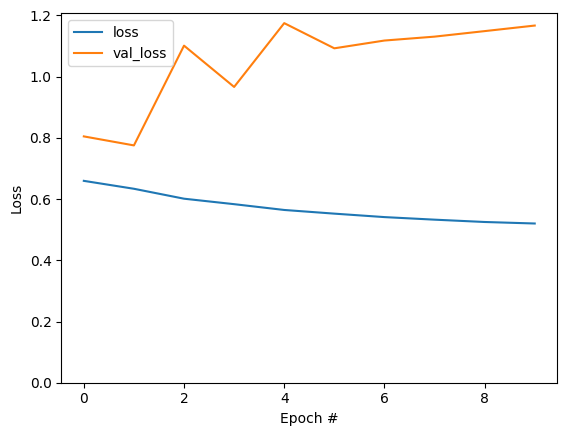

In [55]:
plt.plot(history1.history['loss'], label='loss')
plt.plot(history1.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

Plot training accuracy vs testing accuracy

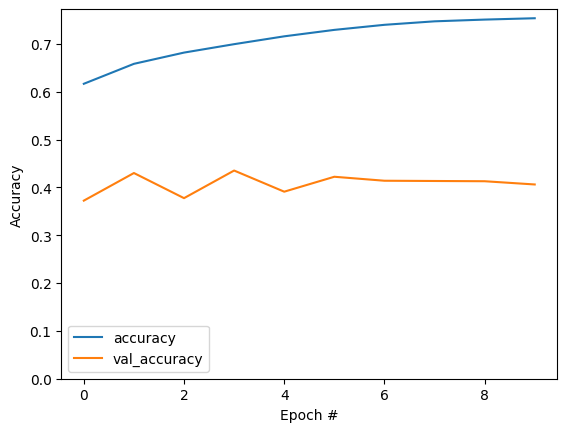

In [56]:
plt.plot(history1.history['accuracy'], label='accuracy')
plt.plot(history1.history['val_accuracy'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

In [57]:
y_pred = text_only_model1.predict(test_ds)
y_pred = [1 if i>=0.5 else 0 for i in y_pred]
print(f'Accuracy == {accuracy_score(y_test,y_pred)}')
print(f'F1 == {f1_score(y_test,y_pred,average=None)}')
print(f'Precision == {precision_score(y_test,y_pred,average=None)}')
print(f'Recall == {recall_score(y_test,y_pred,average=None)}')

61/61 [==============================] - 16s 250ms/step
Accuracy == 0.3801352054082163
F1 == [0.53254902 0.08024691]
Precision == [0.37022901 0.58426966]
Recall == [0.94832402 0.04308202]


# Electra

In [ ]:
# Define TF Hub paths to the BERT encoder and its preprocessor
bert_model_path = (
    "https://tfhub.dev/google/electra_large/2"
)
bert_preprocess_path = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [ ]:
def make_bert_preprocessing_model(sentence_features, seq_length=128):
    """Returns Model mapping string features to BERT inputs.

  Args:
    sentence_features: A list with the names of string-valued features.
    seq_length: An integer that defines the sequence length of BERT inputs.

  Returns:
    A Keras Model that can be called on a list or dict of string Tensors
    (with the order or names, resp., given by sentence_features) and
    returns a dict of tensors for input to BERT.
  """

    input_segments = [
        tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
        for ft in sentence_features
    ]

    # Tokenize the text to word pieces.
    bert_preprocess = hub.load(bert_preprocess_path)
    tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name="tokenizer")
    segments = [tokenizer(s) for s in input_segments]

    # Optional: Trim segments in a smart way to fit seq_length.
    # Simple cases (like this example) can skip this step and let
    # the next step apply a default truncation to approximately equal lengths.
    truncated_segments = segments

    # Pack inputs. The details (start/end token ids, dict of output tensors)
    # are model-dependent, so this gets loaded from the SavedModel.
    packer = hub.KerasLayer(
        bert_preprocess.bert_pack_inputs,
        arguments=dict(seq_length=seq_length),
        name="packer",
    )
    model_inputs = packer(truncated_segments)
    return keras.Model(input_segments, model_inputs)


In [ ]:
bert_preprocess_model = make_bert_preprocessing_model(["text_1"])
bert_preprocess_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_1 (InputLayer)         [(None,)]                 0         
                                                                 
 tokenizer (KerasLayer)      (None, None, None)        0         
                                                                 
 packer (KerasLayer)         {'input_mask': (None, 12  0         
                             8),                                 
                              'input_word_ids': (None            
                             , 128),                             
                              'input_type_ids': (None            
                             , 128)}                             
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________

In [ ]:
idx = np.random.choice(len(train_df_model))
row = train_df_model.iloc[idx]
sample_text_1, sample_text_2 = row["tweetText"], row["tweetText"]
print(f"Text 1: {sample_text_1}")
print(f"Text 2: {sample_text_2}")

test_text = [np.array([sample_text_1])]
text_preprocessed = bert_preprocess_model(test_text)

print("Keys           : ", list(text_preprocessed.keys()))
print("Shape Word Ids : ", text_preprocessed["input_word_ids"].shape)
print("Word Ids       : ", text_preprocessed["input_word_ids"][0, :16])
print("Shape Mask     : ", text_preprocessed["input_mask"].shape)
print("Input Mask     : ", text_preprocessed["input_mask"][0, :16])
print("Shape Type Ids : ", text_preprocessed["input_type_ids"].shape)
print("Type Ids       : ", text_preprocessed["input_type_ids"][0, :16])


Text 1: Huracan sandy dandole duro a NY http://t.co/y6pQu3HZ
Text 2: Huracan sandy dandole duro a NY http://t.co/y6pQu3HZ
Keys           :  ['input_mask', 'input_word_ids', 'input_type_ids']
Shape Word Ids :  (1, 128)
Word Ids       :  tf.Tensor(
[  101 15876 22648  2319  7525  4907  3527  2571  4241  3217  1037  6396
  8299  1024  1013  1013], shape=(16,), dtype=int32)
Shape Mask     :  (1, 128)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 128)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)


In [ ]:
def dataframe_to_dataset(dataframe):
    columns = ['tweetText', 'label']
    dataframe = dataframe[columns].copy()
    labels = dataframe.pop("label")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

## Preprocessing utilities

In [ ]:
resize = (224, 224)
bert_input_features = ["input_word_ids", "input_type_ids", "input_mask"]

In [ ]:
def preprocess_text(text_1):
  text_1 = tf.convert_to_tensor([text_1])
  output = bert_preprocess_model([text_1])
  output = {feature: tf.squeeze(output[feature]) for feature in bert_input_features}
  return output

In [ ]:
def preprocess_text_and_image(sample):
  text = preprocess_text(sample["tweetText"])
  return {"text": text}

In [ ]:
batch_size = 32
auto = tf.data.AUTOTUNE

In [ ]:
def prepare_dataset(dataframe, training=True):
  ds = dataframe_to_dataset(dataframe)
  if training:
      ds = ds.shuffle(len(train_df_model))
  ds = ds.map(lambda x, y: (preprocess_text_and_image(x), y)).cache()
  ds = ds.batch(batch_size).prefetch(auto)
  return ds

In [ ]:
train_ds = prepare_dataset(train_df_model)
test_ds = prepare_dataset(test_df_model, False)

## Model Building

In [ ]:
def create_text_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained BERT model to be used as the base encoder.
    bert = hub.KerasLayer(bert_model_path, name="bert",)
    # Set the trainability of the base encoder.
    bert.trainable = trainable

    # Receive the text as inputs.
    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    inputs = {
        feature: keras.Input(shape=(128,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    # Generate embeddings for the preprocessed text using the BERT model.
    embeddings = bert(inputs)["pooled_output"]

    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the text encoder model.
    return keras.Model(inputs, outputs, name="text_encoder")

## TextOnly model

In [ ]:
def create_text_only_model(
    num_projection_layers=0,
    projection_dims=128,
    dropout_rate=0.1,
    text_trainable=False,
    attention=False
):
    # Receive the text as inputs.
    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    text_inputs = {
        feature: keras.Input(shape=(128,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    text_encoder = create_text_encoder(
        num_projection_layers, projection_dims, dropout_rate, text_trainable
    )

    # Fetch the embedding projections.
    text_projections = text_encoder(text_inputs)
    text_projections = keras.layers.Dropout(dropout_rate)(text_projections)
    outputs = keras.layers.Dense(1, activation="sigmoid")(text_projections)
    return keras.Model([text_inputs], outputs)

In [ ]:
text_only_model2 = create_text_only_model(num_projection_layers=1, projection_dims=128, dropout_rate=0.0)

In [ ]:
text_only_model2.compile(
    optimizer=tf.keras.optimizers.Adam(), loss=loss, metrics=metrics
)
history2 = text_only_model2.fit(train_ds, validation_data=test_ds, epochs=epochs, batch_size=batch_size)

Epoch 1/10
446/446 [==============================] - 510s 1s/step - loss: 0.5977 - accuracy: 0.6582 - precision: 0.6205 - recall: 0.2451 - val_loss: 0.9023 - val_accuracy: 0.3385 - val_precision: 0.3868 - val_recall: 0.0920
Epoch 2/10
446/446 [==============================] - 514s 1s/step - loss: 0.5421 - accuracy: 0.7401 - precision: 0.6904 - recall: 0.4436 - val_loss: 1.0015 - val_accuracy: 0.3115 - val_precision: 0.3094 - val_recall: 0.0787
Epoch 3/10
446/446 [==============================] - 491s 1s/step - loss: 0.5154 - accuracy: 0.7575 - precision: 0.7219 - recall: 0.4801 - val_loss: 1.0126 - val_accuracy: 0.3099 - val_precision: 0.3171 - val_recall: 0.0862
Epoch 4/10
446/446 [==============================] - 491s 1s/step - loss: 0.4924 - accuracy: 0.7712 - precision: 0.7417 - recall: 0.5140 - val_loss: 1.0921 - val_accuracy: 0.3141 - val_precision: 0.3133 - val_recall: 0.0779
Epoch 5/10
446/446 [==============================] - 491s 1s/step - loss: 0.4716 - accuracy: 0.7846

Plot training loss vs testing loss

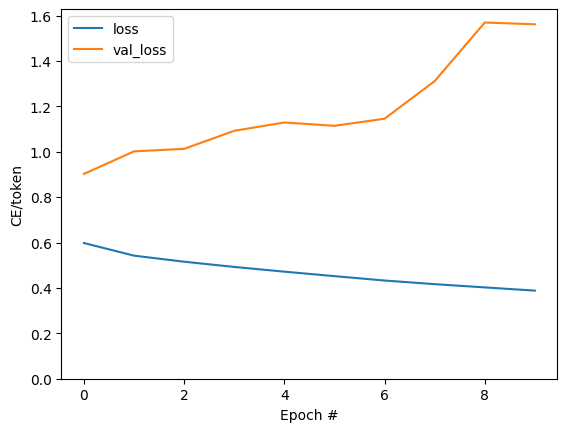

In [ ]:
plt.plot(history2.history['loss'], label='loss')
plt.plot(history2.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

Plot training accuracy vs tersting accuracy

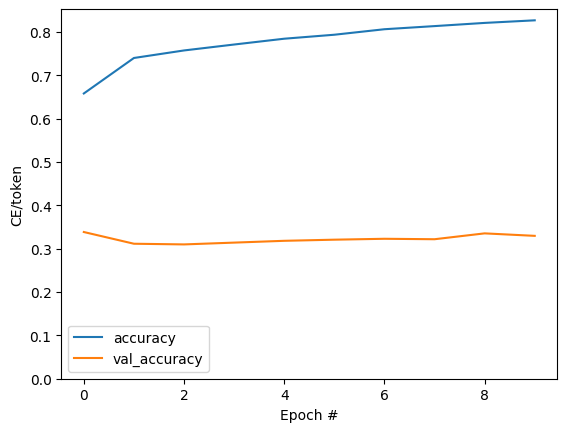

In [ ]:
plt.plot(history2.history['accuracy'], label='accuracy')
plt.plot(history2.history['val_accuracy'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
y_pred = text_only_model2.predict(test_ds)
y_pred = [1 if i>=0.5 else 0 for i in y_pred]
print(f'Accuracy == {accuracy_score(y_test,y_pred)}')
print(f'F1 == {f1_score(y_test,y_pred,average=None)}')
print(f'Precision == {precision_score(y_test,y_pred,average=None)}')
print(f'Recall == {recall_score(y_test,y_pred,average=None)}')

61/61 [==============================] - 64s 977ms/step
Accuracy == 0.3296931877275091
F1 == [0.43340659 0.1795035 ]
Precision == [0.31622835 0.38736264]
Recall == [0.68854749 0.11681856]


## Electra Small

In [58]:
# Define TF Hub paths to the BERT encoder and its preprocessor
bert_model_path = (
    "https://tfhub.dev/google/electra_small/2"
)
bert_preprocess_path = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [59]:
def make_bert_preprocessing_model(sentence_features, seq_length=128):
    """Returns Model mapping string features to BERT inputs.

  Args:
    sentence_features: A list with the names of string-valued features.
    seq_length: An integer that defines the sequence length of BERT inputs.

  Returns:
    A Keras Model that can be called on a list or dict of string Tensors
    (with the order or names, resp., given by sentence_features) and
    returns a dict of tensors for input to BERT.
  """

    input_segments = [
        tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
        for ft in sentence_features
    ]

    # Tokenize the text to word pieces.
    bert_preprocess = hub.load(bert_preprocess_path)
    tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name="tokenizer")
    segments = [tokenizer(s) for s in input_segments]

    # Optional: Trim segments in a smart way to fit seq_length.
    # Simple cases (like this example) can skip this step and let
    # the next step apply a default truncation to approximately equal lengths.
    truncated_segments = segments

    # Pack inputs. The details (start/end token ids, dict of output tensors)
    # are model-dependent, so this gets loaded from the SavedModel.
    packer = hub.KerasLayer(
        bert_preprocess.bert_pack_inputs,
        arguments=dict(seq_length=seq_length),
        name="packer",
    )
    model_inputs = packer(truncated_segments)
    return keras.Model(input_segments, model_inputs)


In [60]:
bert_preprocess_model = make_bert_preprocessing_model(["text_1"])
bert_preprocess_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_1 (InputLayer)         [(None,)]                 0         
                                                                 
 tokenizer (KerasLayer)      (None, None, None)        0         
                                                                 
 packer (KerasLayer)         {'input_mask': (None, 12  0         
                             8),                                 
                              'input_type_ids': (None            
                             , 128),                             
                              'input_word_ids': (None            
                             , 128)}                             
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________

In [61]:
idx = np.random.choice(len(train_df_model))
row = train_df_model.iloc[idx]
sample_text_1, sample_text_2 = row["tweetText"], row["tweetText"]
print(f"Text 1: {sample_text_1}")
print(f"Text 2: {sample_text_2}")

test_text = [np.array([sample_text_1])]
text_preprocessed = bert_preprocess_model(test_text)

print("Keys           : ", list(text_preprocessed.keys()))
print("Shape Word Ids : ", text_preprocessed["input_word_ids"].shape)
print("Word Ids       : ", text_preprocessed["input_word_ids"][0, :16])
print("Shape Mask     : ", text_preprocessed["input_mask"].shape)
print("Input Mask     : ", text_preprocessed["input_mask"][0, :16])
print("Shape Type Ids : ", text_preprocessed["input_type_ids"].shape)
print("Type Ids       : ", text_preprocessed["input_type_ids"][0, :16])


Text 1: #hurricanes #sandy #shark shark in the water on the mean streets of jersey http://t.co/Ky3eClMl
Text 2: #hurricanes #sandy #shark shark in the water on the mean streets of jersey http://t.co/Ky3eClMl
Keys           :  ['input_mask', 'input_type_ids', 'input_word_ids']
Shape Word Ids :  (1, 128)
Word Ids       :  tf.Tensor(
[  101  1001 17035  1001  7525  1001 11420 11420  1999  1996  2300  2006
  1996  2812  4534  1997], shape=(16,), dtype=int32)
Shape Mask     :  (1, 128)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 128)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)


In [62]:
def dataframe_to_dataset(dataframe):
    columns = ['tweetText', 'label']
    dataframe = dataframe[columns].copy()
    labels = dataframe.pop("label")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

## Preprocessing utilities

In [63]:
resize = (224, 224)
bert_input_features = ["input_word_ids", "input_type_ids", "input_mask"]

In [64]:
def preprocess_text(text_1):
  text_1 = tf.convert_to_tensor([text_1])
  output = bert_preprocess_model([text_1])
  output = {feature: tf.squeeze(output[feature]) for feature in bert_input_features}
  return output

In [65]:
def preprocess_text_and_image(sample):
  text = preprocess_text(sample["tweetText"])
  return {"text": text}

In [66]:
batch_size = 32
auto = tf.data.AUTOTUNE

In [67]:
def prepare_dataset(dataframe, training=True):
  ds = dataframe_to_dataset(dataframe)
  if training:
      ds = ds.shuffle(len(train_df_model))
  ds = ds.map(lambda x, y: (preprocess_text_and_image(x), y)).cache()
  ds = ds.batch(batch_size).prefetch(auto)
  return ds

In [68]:
train_ds = prepare_dataset(train_df_model)
test_ds = prepare_dataset(test_df_model, False)

## Model Building

In [69]:
def create_text_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained BERT model to be used as the base encoder.
    bert = hub.KerasLayer(bert_model_path, name="bert",)
    # Set the trainability of the base encoder.
    bert.trainable = trainable

    # Receive the text as inputs.
    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    inputs = {
        feature: keras.Input(shape=(128,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    # Generate embeddings for the preprocessed text using the BERT model.
    embeddings = bert(inputs)["pooled_output"]

    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the text encoder model.
    return keras.Model(inputs, outputs, name="text_encoder")

## TextOnly model

In [70]:
def create_text_only_model(
    num_projection_layers=0,
    projection_dims=128,
    dropout_rate=0.1,
    text_trainable=False,
    attention=False
):
    # Receive the text as inputs.
    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    text_inputs = {
        feature: keras.Input(shape=(128,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    text_encoder = create_text_encoder(
        num_projection_layers, projection_dims, dropout_rate, text_trainable
    )

    # Fetch the embedding projections.
    text_projections = text_encoder(text_inputs)
    text_projections = keras.layers.Dropout(dropout_rate)(text_projections)
    outputs = keras.layers.Dense(1, activation="sigmoid")(text_projections)
    return keras.Model([text_inputs], outputs)

In [71]:
text_only_model3 = create_text_only_model(num_projection_layers=1, projection_dims=128, dropout_rate=0.0)

In [72]:
text_only_model3.compile(
    optimizer=tf.keras.optimizers.Adam(), loss=loss, metrics=metrics
)
history3 = text_only_model3.fit(train_ds, validation_data=test_ds, epochs=epochs, batch_size=batch_size)

Epoch 1/10
446/446 [==============================] - 45s 76ms/step - loss: 0.6031 - accuracy: 0.6490 - precision: 0.5852 - recall: 0.2426 - val_loss: 0.6845 - val_accuracy: 0.5803 - val_precision: 0.7132 - val_recall: 0.5543
Epoch 2/10
446/446 [==============================] - 32s 72ms/step - loss: 0.5739 - accuracy: 0.7071 - precision: 0.6300 - recall: 0.3600 - val_loss: 0.7631 - val_accuracy: 0.4774 - val_precision: 0.6384 - val_recall: 0.3861
Epoch 3/10
446/446 [==============================] - 32s 73ms/step - loss: 0.5546 - accuracy: 0.7241 - precision: 0.6632 - recall: 0.4022 - val_loss: 0.9128 - val_accuracy: 0.3947 - val_precision: 0.5368 - val_recall: 0.2601
Epoch 4/10
446/446 [==============================] - 32s 72ms/step - loss: 0.5351 - accuracy: 0.7406 - precision: 0.6936 - recall: 0.4404 - val_loss: 1.0285 - val_accuracy: 0.3781 - val_precision: 0.5102 - val_recall: 0.2287
Epoch 5/10
446/446 [==============================] - 32s 72ms/step - loss: 0.5185 - accuracy: 0

Plot training loss vs testing loss

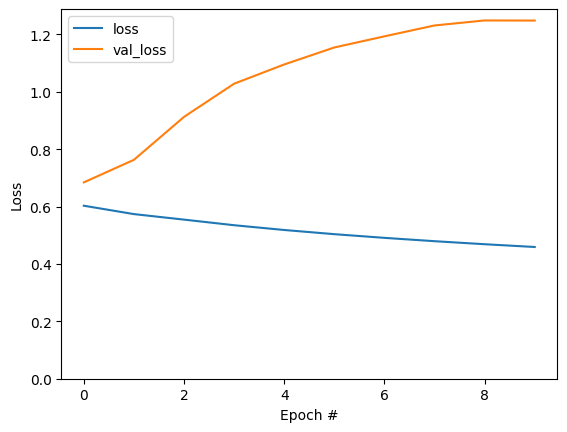

In [73]:
plt.plot(history3.history['loss'], label='loss')
plt.plot(history3.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

Plot training accuracy vs testing accuracy

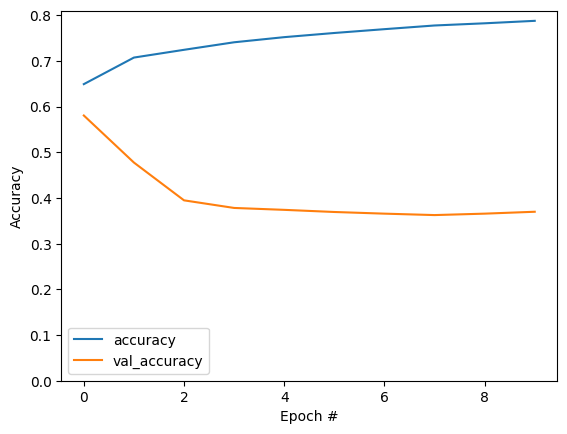

In [74]:
plt.plot(history3.history['accuracy'], label='accuracy')
plt.plot(history3.history['val_accuracy'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

In [75]:
y_pred = text_only_model3.predict(test_ds)
y_pred = [1 if i>=0.5 else 0 for i in y_pred]
print(f'Accuracy == {accuracy_score(y_test,y_pred)}')
print(f'F1 == {f1_score(y_test,y_pred,average=None)}')
print(f'Precision == {precision_score(y_test,y_pred,average=None)}')
print(f'Recall == {recall_score(y_test,y_pred,average=None)}')

61/61 [==============================] - 4s 60ms/step
Accuracy == 0.4456578263130525
F1 == [0.47796278 0.40909091]
Precision == [0.36802413 0.61809045]
Recall == [0.68156425 0.30571665]
